In [1]:
# !pip install git+https://github.com/tensorflow/examples.git

In [2]:
# shutil.rmtree('../logs')

In [1]:
## Importing required packages
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import os
import gc
import json
import pickle
import glob
import math
import shutil
from tqdm import tqdm_notebook as tqdm

import numpy as np
import math
from numpy import asarray
import cv2
from os import listdir
import random

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
from IPython.display import clear_output

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report


import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, UpSampling2D, Conv2D, Activation, LeakyReLU, BatchNormalization,Input,Conv2DTranspose,Dropout
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPool2D
from tensorflow.keras.layers import concatenate, add

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler,Callback

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import MeanSquaredError, binary_crossentropy


from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

# 1. Prepare Datasets

## (1) Make ground truth

In [426]:
annotations = json.load(open('cubi/cubi.json'))
img_dir = 'images/train/'

In [ ]:
['WI', 'O', 'S', 'EV', 'Os']

In [429]:
annotations[0]['regions'][0]['region_attributes']

{'cubi': 'W'}

In [436]:
shutil.rmtree('ground_truth/object/')

In [437]:
def make_ground_truth(annotations):
    for a in tqdm(annotations):
        try:
            file_name = a['filename']
            img_path = os.path.join(img_dir, file_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            # img = cv2.imread(img_path, 3)
            poly_img = np.ones(shape=img.shape)
            for r in a['regions']:
                if r['region_attributes']['cubi'] != 'W':
                    p = np.array(list(zip(r['shape_attributes']['all_points_x'], r['shape_attributes']['all_points_y'])), dtype='int32')
                    poly = cv2.fillPoly(poly_img, [p], 0)
            cv2.imwrite(f"ground_truth/object/{str(file_name.split('.')[0])}_object.jpg", poly*255)
        except:
            pass

In [438]:
make_ground_truth(annotations)

## (2) Preprocessing Dataset

In [5]:
def resize_image(img, size=(512,512)):

    h, w = img.shape[:2]
    c = img.shape[2] if len(img.shape)>2 else 1

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.ones((dif, dif), dtype=img.dtype)*255
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        mask = np.ones((dif, dif, c), dtype=img.dtype)*255
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

In [6]:
# split train, test

file_list = os.listdir('images/train/')
train_list, test_list = train_test_split(file_list, test_size=0.1, random_state=415)

In [7]:
train_image = [resize_image(cv2.imread(os.path.join('images/train/', x))) for x in train_list]
test_image = [resize_image(cv2.imread(os.path.join('images/train/', x))) for x in test_list]

In [8]:
train_mask = [resize_image(cv2.imread(os.path.join('ground_truth', x.split(".")[0]+'_gt.jpg'))) for x in train_list]
test_mask = [resize_image(cv2.imread(os.path.join('ground_truth', x.split(".")[0]+'_gt.jpg'))) for x in test_list]

## (3) Display samples

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(display_list[i], cmap='gray')
        plt.axis('off')
    plt.show()

In [32]:
train_temp = np.array(train_list)
test_temp = np.array(test_list)

In [33]:
np.where((train_temp=='206.jpg') | (train_temp=='221.jpg') | (train_temp=='1545.jpg'))

(array([  2, 250]),)

In [34]:
np.where((test_temp=='206.jpg') | (test_temp=='221.jpg') | (test_temp=='1545.jpg'))

(array([35]),)

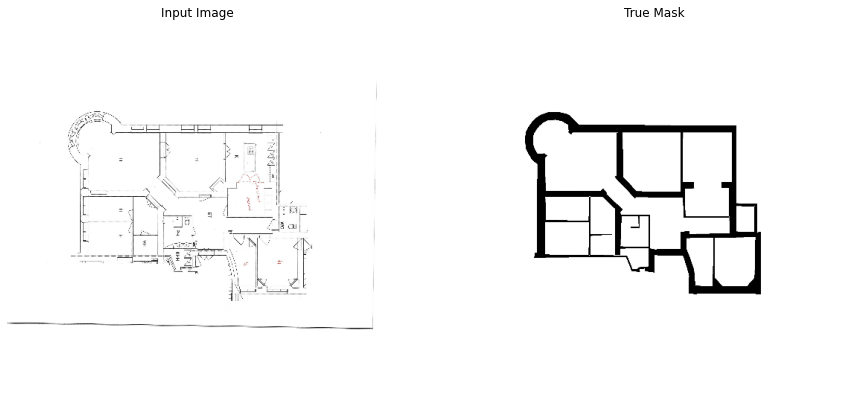

In [37]:
display([train_image[2], train_mask[2]])

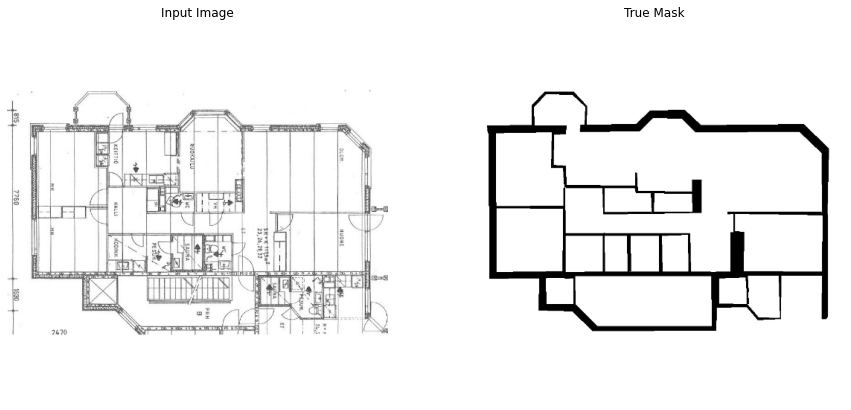

In [38]:
display([train_image[250], train_mask[250]])

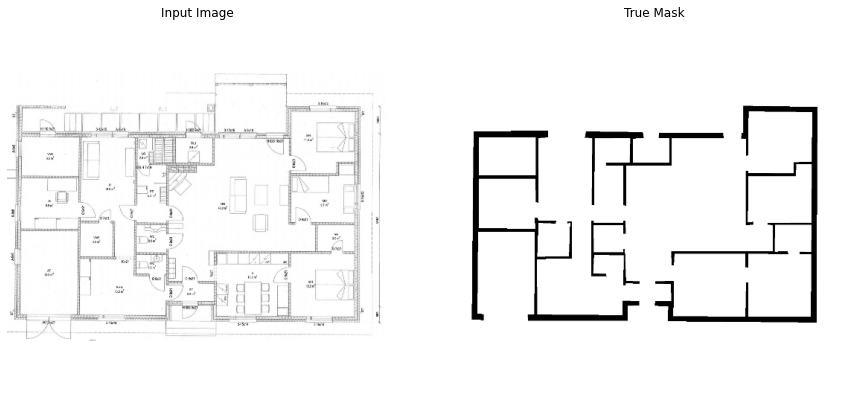

In [39]:
display([test_image[35], test_mask[35]])

# 2. Model Development

## (1) Define Metric function

In [140]:
def dice_coef(y_true, y_pred, smooth=0): # same as F1-score
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_coef(y_true, y_pred, smooth=1): # same as Jaccard index
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
    iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
    return iou

## (2) Define Loss function

In [141]:
def dice_loss_v1(y_true, y_predict):
    return (1-dice_coef(y_true, y_predict))

def iou_loss(y_true, y_predict):
    return (1-iou_coef(y_true, y_predict))

def bce_dice_loss(y_true, y_predict):
    return binary_crossentropy(y_true, y_predict) + (1-dice_coef(y_true, y_predict))

In [142]:
def dice_loss_v2(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.math.sigmoid(y_pred)
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)

    return 1 - numerator / denominator

## (3) Layer construction

In [483]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    '''returns a block of two 3x3 convolutions, each  followed by a rectified linear unit (ReLU)'''
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [484]:
def get_unet(input_img, n_filters, dropout, batchnorm):
    """Function to define the UNET Model"""
    # Contracting Path
    c1 = conv2d_block(input_img, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    p1 = MaxPooling2D((2, 2))(c1)
    p1 = Dropout(dropout)(p1)
    
    c2 = conv2d_block(p1, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    p2 = MaxPooling2D((2, 2))(c2)
    p2 = Dropout(dropout)(p2)
    
    c3 = conv2d_block(p2, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    p3 = MaxPooling2D((2, 2))(c3)
    p3 = Dropout(dropout)(p3)
    
    c4 = conv2d_block(p3, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    p4 = MaxPooling2D((2, 2))(c4)
    p4 = Dropout(dropout)(p4)
    
    c5 = conv2d_block(p4, n_filters = n_filters * 16, kernel_size = 3, batchnorm = batchnorm)
    
    # Expansive Path
    u6 = UpSampling2D()(c5)
    u6 = Conv2D(filters = n_filters *8, kernel_size = (2, 2), kernel_initializer = 'he_normal', padding = 'same')(u6)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)
    
    u7 = UpSampling2D()(c6)
    u7 = Conv2D(filters = n_filters *4, kernel_size = (2, 2), kernel_initializer = 'he_normal', padding = 'same')(u7)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)
    
    u8 = UpSampling2D()(c7)
    u8 = Conv2D(filters = n_filters *2, kernel_size = (2, 2), kernel_initializer = 'he_normal', padding = 'same')(u8)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters * 2, kernel_size = 3, batchnorm = batchnorm)
    
    u9 = UpSampling2D()(c8)
    u9 = Conv2D(filters = n_filters *1, kernel_size = (2, 2), kernel_initializer = 'he_normal', padding = 'same')(u9)
    u9 = concatenate([u9, c1])
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters * 1, kernel_size = 3, batchnorm = batchnorm)
    
    outputs = Conv2D(3, (1, 1), activation='sigmoid')(c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model

## (4) Model Compiling

In [485]:
input_img = Input((512, 512, 3), name='img')
model = get_unet(input_img, n_filters=4, dropout=0.2, batchnorm=True)
model.compile(optimizer=Adam(),
              loss=dice_loss_v1,
              metrics=[dice_coef, iou_coef])

In [414]:
model.summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv2d_253 (Conv2D)             (None, 512, 512, 4)  112         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_198 (BatchN (None, 512, 512, 4)  16          conv2d_253[0][0]                 
__________________________________________________________________________________________________
activation_198 (Activation)     (None, 512, 512, 4)  0           batch_normalization_198[0][0]    
___________________________________________________________________________________________

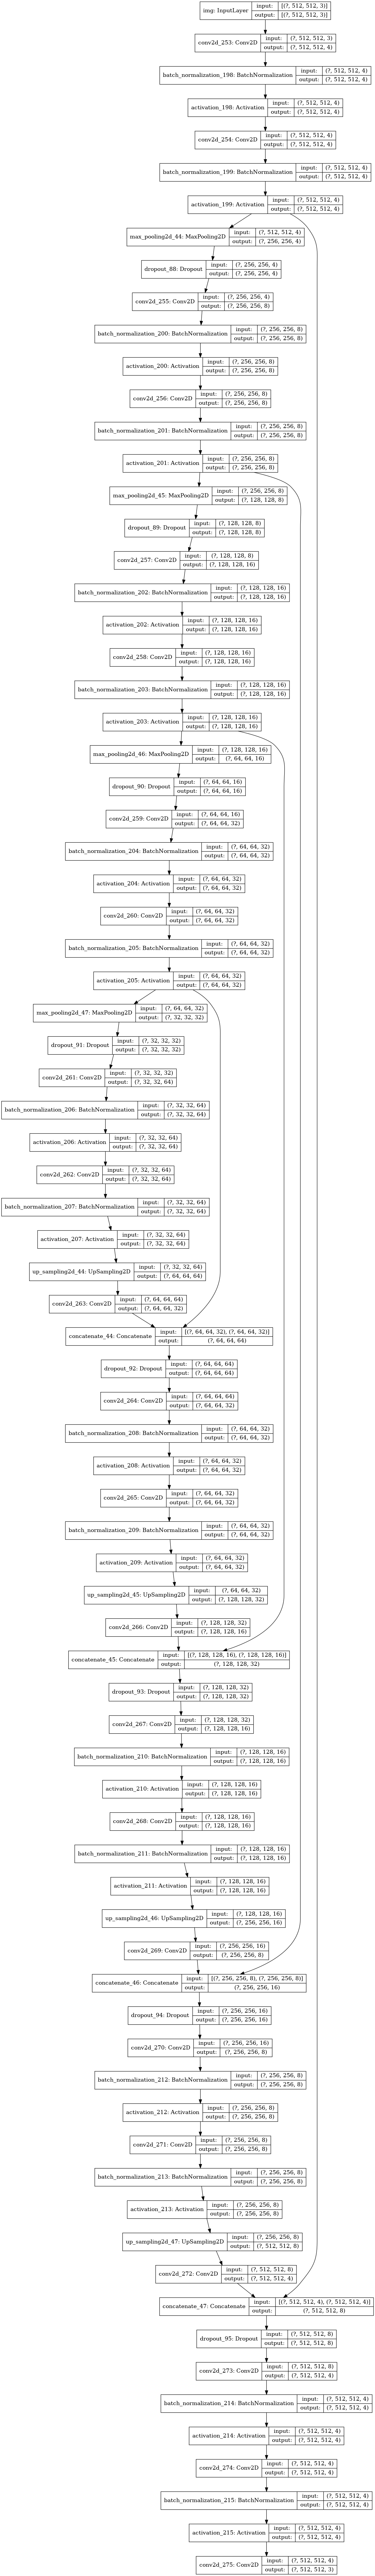

In [415]:
plot_model(model, show_shapes=True)

## (5) Callbacks

In [290]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [327]:
def show_predictions(dataset=None, num=1, evaluation=False):
    
    if dataset:
        
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
            
            
            if evaluation:
                
                y_true = tf.where(mask<=0.01, 0, 1)
                y_pred = tf.where(pred_mask<=0.01, 0, 1)
                # y_pred = pred_mask/2
                
                y_true = tf.reshape(y_true, (-1, ))
                y_pred = tf.reshape(y_pred, (-1, ))
                
                print("Classification Report : ", 
                      classification_report(y_true, y_pred))
                
                print("Dice Coefficient: ", 
                      tf.get_static_value(dice_coef(mask, pred_mask)))

                print("Jaccard Index : ", 
                      tf.get_static_value(iou_coef(mask,pred_mask)))
                
    else:
        display([train_image[250], train_mask[250],
                 create_mask(model.predict((train_image[250]/255.)[tf.newaxis, ...]))])

In [292]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nAfter {} epochs sample \n'.format(epoch+1))

In [293]:
cp = ModelCheckpoint('checkpoints/unet_model.h5', 
                     monitor='val_dice_coef', 
                     verbose=1,
                     save_best_only=True, 
                     mode='max')

log_dir = '../logs/{}'.format(datetime.now().strftime("%Y%m%d-%H%M%S"))

tb = TensorBoard(log_dir=log_dir)

es = EarlyStopping(monitor='val_loss', patience=15)

## (6) Training

In [475]:
BUFFER_SIZE = 8
STEPS_PER_EPOCH = int(len(train_list) / BUFFER_SIZE)
VALIDATION_STEPS = int(len(test_list) / BUFFER_SIZE)

In [477]:
def normalize(input_image, input_mask):

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image = tf.cast(input_image, tf.float32)/255.
    input_mask = tf.cast(input_mask, tf.float32)/255.
    

    return input_image, input_mask

In [155]:
%timeit
train_tensor = tf.data.Dataset.from_tensor_slices((train_image, train_mask)).shuffle(200).map(normalize)
test_tensor = tf.data.Dataset.from_tensor_slices((test_image, test_mask)).shuffle(200).map(normalize)

In [476]:
%time
train_dataset = train_tensor.prefetch(tf.data.experimental.AUTOTUNE).batch(BUFFER_SIZE).repeat()
test_dataset = test_tensor.prefetch(tf.data.experimental.AUTOTUNE).batch(BUFFER_SIZE).repeat()

CPU times: user 15 µs, sys: 2 µs, total: 17 µs
Wall time: 42.7 µs


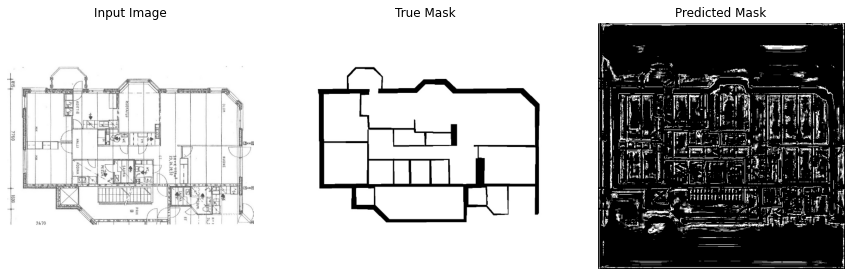


After 450 epochs sample 

44/44 [==============================] - 5s 106ms/step - loss: 0.0101 - dice_coef: 0.9899 - iou_coef: 0.9799 - val_loss: 0.0181 - val_dice_coef: 0.9819 - val_iou_coef: 0.9645


In [486]:
history = model.fit(train_dataset,
                    steps_per_epoch = STEPS_PER_EPOCH,
                    validation_steps = VALIDATION_STEPS,
                    validation_data = test_dataset,
                    epochs = 450, 
                    # initial_epoch = 300,
                    verbose=1,
                    callbacks=[cp, es, tb, DisplayCallback()])

## Training graph

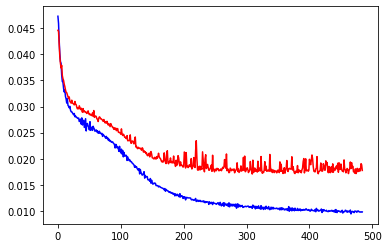

In [411]:
plt.plot(history.history['loss'][15:], 'b')
plt.plot(history.history['val_loss'][15:], 'r')

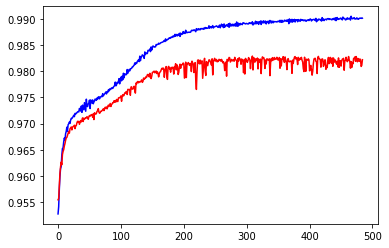

In [412]:
plt.plot(history.history['dice_coef'][15:], 'b')
plt.plot(history.history['val_dice_coef'][15:], 'r')

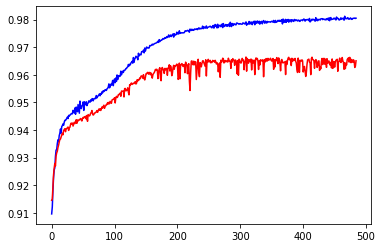

In [413]:
plt.plot(history.history['iou_coef'][15:], 'b')
plt.plot(history.history['val_iou_coef'][15:], 'r')

# 3. Evaluation

## (1) Random samples

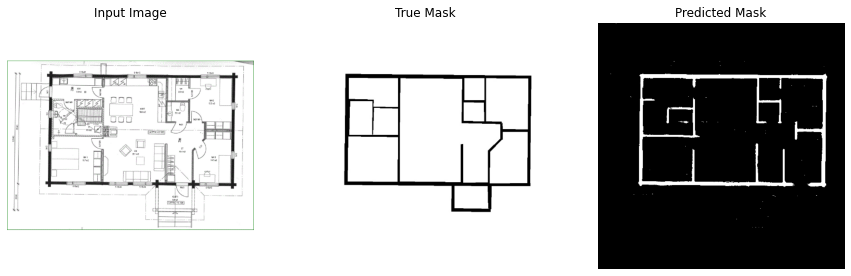

Classification Report :                precision    recall  f1-score   support

           0       0.79      0.77      0.78    447483
           1       0.98      0.98      0.98   5843973

    accuracy                           0.97   6291456
   macro avg       0.89      0.88      0.88   6291456
weighted avg       0.97      0.97      0.97   6291456

Dice Coefficient:  0.98274046
Jaccard Index :  0.9660015


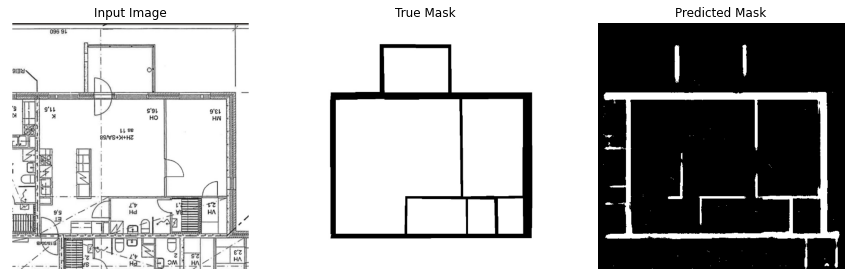

Classification Report :                precision    recall  f1-score   support

           0       0.63      0.71      0.67    390588
           1       0.98      0.97      0.98   5900868

    accuracy                           0.96   6291456
   macro avg       0.81      0.84      0.82   6291456
weighted avg       0.96      0.96      0.96   6291456

Dice Coefficient:  0.9758144
Jaccard Index :  0.95295733


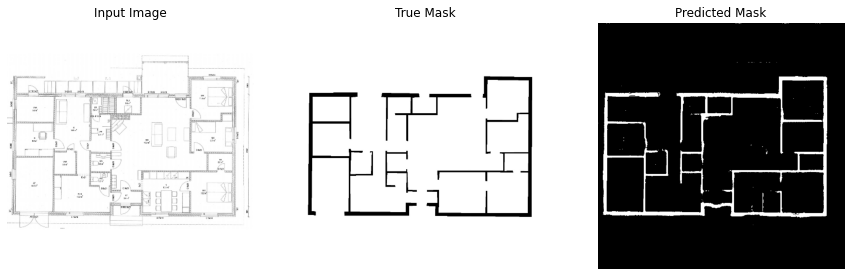

Classification Report :                precision    recall  f1-score   support

           0       0.85      0.71      0.77    461946
           1       0.98      0.99      0.98   5829510

    accuracy                           0.97   6291456
   macro avg       0.91      0.85      0.88   6291456
weighted avg       0.97      0.97      0.97   6291456

Dice Coefficient:  0.9828046
Jaccard Index :  0.96605724


In [328]:
show_predictions(test_dataset, 3, evaluation=True)

## (2) Specific samples

1. Included curved line - **1545.jpg**
2. Complex sample - **221.jpg**
3. Large size sample - **206.jpg**

In [439]:
sample_list = ['221.jpg', '1545.jpg', '206.jpg']

In [440]:
sample_image = [resize_image(cv2.imread(os.path.join('images/train/', x))) for x in sample_list]
sample_mask = [resize_image(cv2.imread(os.path.join('ground_truth/object/', x.split(".")[0]+'_object.jpg'))) for x in sample_list]
sample_tensor = tf.data.Dataset.from_tensor_slices((sample_image, sample_mask)).map(normalize).batch(1)

In [466]:
def obejct_eval(sample_mask, sample_result):
    for sm, sr in zip(sample_mask, sample_result):
        y_true = np.where(sm/255<=0.1, 0, 1)
        y_pred = np.where(sr<=0.1, 0, 1)
        # y_pred = pred_mask/2

        y_true = np.reshape(y_true, (-1, ))
        y_pred = np.reshape(y_pred, (-1, ))

        print("Classification Report : ", 
              classification_report(y_true, y_pred))

In [467]:
sample_result = [cv2.imread(os.path.join('output/', x.split('.')[0]+'_object.jpg'))/255 for x in sample_list]

In [468]:
obejct_eval(sample_mask, sample_result)

Classification Report :                precision    recall  f1-score   support

           0       0.89      0.59      0.71     29889
           1       0.98      1.00      0.99    756543

    accuracy                           0.98    786432
   macro avg       0.94      0.79      0.85    786432
weighted avg       0.98      0.98      0.98    786432

Classification Report :                precision    recall  f1-score   support

           0       0.86      0.20      0.32     12915
           1       0.99      1.00      0.99    773517

    accuracy                           0.99    786432
   macro avg       0.92      0.60      0.66    786432
weighted avg       0.98      0.99      0.98    786432

Classification Report :                precision    recall  f1-score   support

           0       0.86      0.47      0.61     32913
           1       0.98      1.00      0.99    753519

    accuracy                           0.97    786432
   macro avg       0.92      0.74      0.80    786432

## (3) Save model & output images

In [332]:
model.save('model/UNet_v1.h5')

In [385]:
def save_result(sample_list):
    
    img_dic = {'221':test_image[35], '1545':train_image[2], '206':train_image[250]}
    
    for nm in sample_list:
        nm = nm.split('.')[0]
        pred_mask = create_mask(model.predict((img_dic[nm]/255.)[tf.newaxis, ...]))
        pred_mask_inv = np.where(pred_mask!=0, 0, 1)
        cv2.imwrite(f'{nm}_out.jpg', pred_mask_inv*255)
        plt.imshow(pred_mask_inv, cmap='gray')

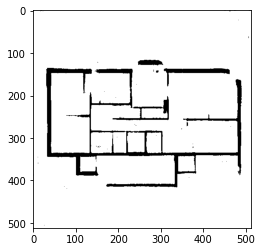

In [386]:
save_result(sample_list)